In [3]:

import pyfeltor.dg as dg
import json
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
import simplesimdb as simplesim # this one is our own database manager
import subprocess # to capture errors from the simulations
import yaml
import pandas as pd
import blob.input

In [18]:
def generate_default( kappa = 0.000457, amplitude = 1, sigma = 10):
    return {
    "grid":
    {
        "n" :  3,
        "Nx" : 40,
        "Ny" : 40,
        "lx"  : 200,
        "ly"  : 200
    },
    "init":
    {
        "amplitude"  : amplitude,
        "sigma"  : sigma,
        "posX"  : 0.3,
        "posY"  : 0.5,
        "flr"  : "gamma_inv"
    },
    "timestepper":
    {
        "tableau" : "Bogacki-Shampine-4-2-3",
        "rtol" : 1e-6,
        "atol" : 1e-7
    },
    "bc" : ["DIR", "PER"],
    "diffusion":
    {
        "nu" : 0,
        "order": 2,
        "direction" : "forward"
    },
    "advection":
    {
        "type" : "upwind", # or div-upwind or div-upwind-multiply 
        # (but those create oscillations and crash and I don't find a bug in the code)
        "dphi_dir" : "centered",
    },
    "elliptic":
    {
        "stages" : 3,
        "eps_pol"   : [1e-6, 1, 1],
        "eps_gamma" : [1e-7, 1, 1],
        "direction" : "centered"
    },
    "model" :
    {
        "curvature" : kappa,
        "tau" : 0
    },
    "output":
    {
        "type" : "netcdf",
        "tend" : 2000,
        "maxout" : 5,
        "n" : 3,
        "Nx" : 40,
        "Ny" : 40
    }
    }

In [19]:
m = simplesim.Manager(directory='data', executable='./blob/toefl', filetype='nc')
# Let's see what id the database allocates to our input
print(m.jsonfile(generate_default()))
# Takes about a minute ...
ncfile=m.create(generate_default(), error = "display")
print( ncfile)

data/639a5fc2a7b3e5240ec39321a675ef6416cc0797.json
Running simulation 639a5f...cc0797.nc
data/639a5fc2a7b3e5240ec39321a675ef6416cc0797.nc


In [20]:
ncin = Dataset( ncfile, 'r', format="NETCDF4")
print( "FILE CONTENTS")
for v in ncin.variables:
    if v == "time" : 
        print(f"{v} {ncin.variables[v].shape}")
    elif v == "diag_time" : 
        print(f"{v} {ncin.variables[v].shape}")
    else : 
        print( f"{v} {ncin.variables[v].shape}",
            f"\t{ ncin.variables[v].long_name}")
ncin.close()

FILE CONTENTS
time (6,)
y (120,) 	y-coordinate in Computational coordinate system
x (120,) 	x-coordinate in Computational coordinate system
ne (6, 120, 120) 	Electron density in 2d
gy (6, 120, 120) 	Ion-gyro-center density in 2d
phi (6, 120, 120) 	Electric potential
psi (6, 120, 120) 	Gyro-center potential
lapNe (6, 120, 120) 	+Delta ne
lapNi (6, 120, 120) 	+Delta ni
lapPhi (6, 120, 120) 	+Delta Phi
Se (6, 120, 120) 	 ne ln ne
Si (6, 120, 120) 	 tau_i ni ln ni
U (6, 120, 120) 	 0.5 ni u_E^2
xc (120, 120) 	x-coordinate in Cartesian coordinate system
yc (120, 120) 	y-coordinate in Cartesian coordinate system
weights (120, 120) 	Gaussian Integration weights


In [27]:
def create_grid( ncfile):
    pp = json.loads(ncin.inputfile)
    g = pp["grid"]
    return dg.Grid( [0,0], [g["ly"], g["lx"]], [g["n"], g["n"]], [g["Ny"], g["Nx"]])

In [28]:
help( dg.create.elliptic)

Help on function elliptic in module pyfeltor.dg.create.elliptic:

elliptic(grid, bcs, directions, sigma, jumpfactor=1)



Time =  2000.0


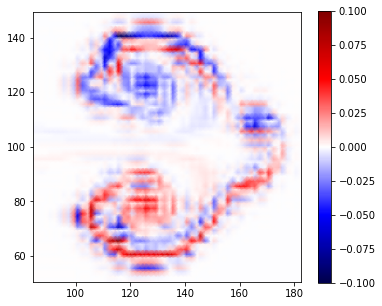

In [42]:
ncin = Dataset( ncfile, 'r', format="NETCDF4")

x = ncin["x"][:]
y = ncin["y"][:]
vo = ncin["phi"][-1,:,:]
time = ncin["time"][:]
grid = create_grid( ncfile)

laplace = dg.create.elliptic( grid, [dg.bc.PER,dg.bc.DIR], [dg.direction.forward,dg.direction.forward], np.ones( grid.size()))
plt.figure(figsize=(6, 5))
plt.pcolormesh(x[50:110],y[30:90],laplace.dot(vo.ravel()).reshape( grid.shape)[30:90,50:110],
               shading='gouraud',
               cmap = 'seismic', vmin = -0.1, vmax = 0.1 )
plt.colorbar()
print( "Time = ", time[-1])
plt.axis('scaled')
plt.show()

In [75]:
inputfile = generate_default()
inputfile["advection"]["type"] = "div-upwind" # does not really work
inputfile["output"]["tend"] = 200
ncfile=m.create(inputfile, error = "display")

Existing simulation 8a020e...1d7810.nc


Time =  200.0


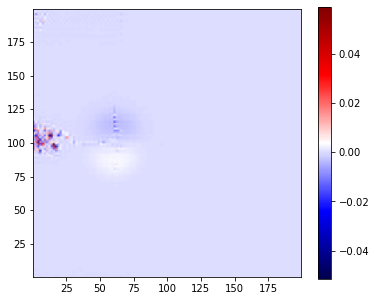

In [76]:
ncin = Dataset( ncfile, 'r', format="NETCDF4")

x = ncin["x"][:]
y = ncin["y"][:]
vo = ncin["phi"][-1,:,:]
time = ncin["time"][:]
grid = create_grid( ncfile)

laplace = dg.create.elliptic( grid, [dg.bc.PER,dg.bc.DIR], [dg.direction.forward,dg.direction.forward], np.ones( grid.size()))
plt.figure(figsize=(6, 5))
plt.pcolormesh(x,y,laplace.dot(vo.ravel()).reshape( grid.shape),
               shading='gouraud',
               cmap = 'seismic')#, vmin = -0.1, vmax = 0.1 )
plt.colorbar()
print( "Time = ", time[-1])
plt.axis('scaled')
plt.show()

Not sure what the problem here is